## 1. Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [2]:
# beautifying matplotlib output 

import matplotlib_inline

plt.rcParams['font.family'] = 'Source Code Pro', 'serif'
#plt.style.use('./rose-pine-dawn.mplstyle')
#plt.rcParams['figure.dpi'] = 150
#plt.rcParams['savefig.dpi'] = 150

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## 2. Data structures creation

In [3]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]


# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, battery_level=100):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost

## 3. Helper functions

In [4]:
def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points a and b.

    Parameters:
    - a: Tuple representing the x and y coordinates of point a (e.g., (x1, y1))
    - b: Tuple representing the x and y coordinates of point b (e.g., (x2, y2))

    Returns:
    - The Manhattan distance between points a and b.
    """
    (x1, y1) = a
    (x2, y2) = b

    return abs(x1 - x2) + abs(y1 - y2)

#### I. Generate a random grid function

In [5]:
def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])

In [6]:
def generate_environment():
    # define the size of the grid and the probability of an obstacle in each cell
    grid_size = 10
    obstacle_probability = 0.3  # 20% chance of being an obstacle

    # generate a random grid
    grid = generate_random_grid(grid_size, obstacle_probability)

    # define start and goal positions
    start = (0, 0)
    goal = (grid_size - 1, grid_size - 1)

    # ensure start and goal are not obstacles
    grid[start] = 0
    grid[goal] = 0

    # create and return the environment
    return Environment(grid, start, goal), grid


#### II. Visualize the grid and battery using matplotlib

In [28]:
def visualize_grid_and_path(grid, path, time, battery_levels, trace_battery, trace=None):
    grid_array = np.array(grid)  # convert grid to numpy array for plotting.

    # create figures for grid/path
    fig_grid, ax_grid = plt.subplots()  # for grid and path

    # plot grid and path
    ax_grid.imshow(grid_array, cmap='Greys', alpha=0.3)  # grid background.
    start = path[0]
    goal = path[-1]
    ax_grid.plot(start[1], start[0], color='skyblue', marker='s', markersize=10)  # start position in blue.
    ax_grid.plot(goal[1], goal[0], color='lightgreen', marker='s', markersize=10)  # goal position in green.
    xs, ys = zip(*path)  # extract X and Y coordinates of the path.
    ax_grid.plot(ys, xs, color='salmon', linestyle='-', linewidth=2)  # plot the path in red.
    
    if trace:
        for i, position in enumerate(trace):
            ax_grid.text(position[1], position[0], trace_battery[i], ha='center', va='center', color='black')

    ax_grid.set_title("Grid and Path")

    ax_grid.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax_grid.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax_grid.grid(which="minor", color="dimgray", linestyle='-', linewidth=1)
    ax_grid.tick_params(which="minor", size=0)
    ax_grid.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

    # adjust layout and show plots
    plt.tight_layout()
    plt.show()

## 4. Definiton of Environment and Agent classes

#### I. Environment Class represents the grid and handles state transitions

In [8]:
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # The grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # Starting position of the agent.
        self.goal = goal  # Goal position the agent aims to reach.
        self.time = 0

    # Returns the possible actions from a given state.
    def possible_actions(self, state):
        possible_actions = ["UP", "DOWN", "LEFT", "RIGHT"]
        x, y = state

        # Remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove("UP")
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove("DOWN")
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove("LEFT")
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove("RIGHT")

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def state_after_move(self, current_state, action, mode="move"):
        x, y = current_state

        if mode == "move":
            self.time += 1

        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal
    
    # recharge agent battery
    def recharge_battery(self, battery_level):
        time_took = 0
        levels = []

        # simulate charging behaviour over time
        for i in range(10):
            battery_level += 10
            levels.append(battery_level)
            time_took += 1

        self.time += time_took

        return (battery_level, levels, time_took)

#### II. Agent class to traverse inside a world using finding optimum paths

In [9]:
class Agent:
    def __init__(self, env):
        self.env = env

        self.state = self.env.initial # initial position of agent in the grid (x, y)
        self.steps_to_goal = [] # positions the agent needs to take to reach goal (needs to be generated by search algorithm)
        self.paths_taken = [self.state] # positions the agent goes through when moving
        self.trace = []
        self.trace_battery = []

        self.recharge_count = 0 # initialize a recharge counter
        self.battery_level = 100 # initialize battery at 100%
        self.battery_levels = [self.battery_level] # initialize an empty list for keeping track of battery levels


    # searching algorithms to find the lowest cost path from the initial state to the goal
    # ------------------------------------------------------------------------------------
    def uniform_cost_search(self):
        frontier = PriorityQueue()  # priority queue for UCS

        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0)

        came_from = {}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.possible_actions(current_node.state):
                new_state = self.env.state_after_move(current_node.state, action, mode="search")
                new_cost = cost_so_far[current_node.state] + 1  # assuming uniform cost for simplicity

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    self.trace.append(new_state)
                    
                    battery_status, time_took = self.check_battery_and_recharge()

                    self.battery_level = self.battery_level - 10
                    self.trace_battery.append(self.battery_level)

                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    new_node = Node(state=new_state, parent=current_node, action=action, path_cost=new_cost)

                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state

        return []


    def a_star_search(self):
        frontier = PriorityQueue()

        # the start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0)  # priority is f-cost, initially the heuristic cost from start to goal

        came_from = {}  # tracks the best path to a node
        cost_so_far = {self.env.initial: 0}  # tracks the g-cost (cost so far to reach a node)

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.possible_actions(current_node.state):
                new_state = self.env.state_after_move(current_node.state, action, mode="search")
                new_cost = cost_so_far[current_node.state] + 1  # assuming uniform cost for simplicity

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    self.trace.append(new_state)
                    
                    battery_status, time_took = self.check_battery_and_recharge()

                    self.battery_level = self.battery_level - 10
                    self.trace_battery.append(self.battery_level)

                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f(p) = cost(p) + h(n)
                    new_node = Node(state=new_state, parent=current_node, action=action, path_cost=new_cost)

                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state

        return []
    #
    # ------------------------------------------------------------------------------------


    def reconstruct_path(self, came_from, current):
        path = []

        while current in came_from:
            path.append(current)
            current = came_from[current]

        path.append(self.env.initial)
        path.reverse()
        
        previous = (self.env.initial)

        for state in path:
            if state != self.env.initial:
                x, y = previous
                x1, y1 = state

                dx = x1 - x
                dy = y1 - y

                self.steps_to_goal.append((dx, dy))
                previous = state

        return path


    def check_battery_and_recharge(self):
        if self.battery_level <= 0:
            self.battery_level, battery_levels, time_took = self.env.recharge_battery(battery_level=self.battery_level)

            self.recharge_count += 1  # Increment counter on recharge
            self.battery_levels += battery_levels
            
            return (True, time_took)
        else:
            return (False, 0)

    
    def boot(self):
        # move according to the steps generated by searching algorithm
        for step in self.steps_to_goal:
            # how much distance to move
            dx, dy = step
            
            # simulate waiting behavior of agent for charging
            need_recharge, time_took = self.check_battery_and_recharge()
            
            if need_recharge is True:
                # the agent is waiting
                for i in range(time_took):
                    self.paths_taken.append(self.state)
            
            # agent movement in the grid
            if dx != 0 or dy != 0:
                if dx > 0:
                    next_state = self.env.state_after_move(current_state=self.state, action="DOWN")
                if dx < 0:
                    next_state = self.env.state_after_move(current_state=self.state, action="UP")
                if dy > 0:
                    next_state = self.env.state_after_move(current_state=self.state, action="RIGHT")
                if dy < 0:
                    next_state = self.env.state_after_move(current_state=self.state, action="LEFT")

                self.state = next_state
                self.paths_taken.append(next_state)

                # decrease battery life by 10%
                self.battery_level -= 10
                self.battery_levels.append(self.battery_level)


    def shutdown(self):
        # reset all values to default
        self.env.time = 0

        self.state = self.env.initial
        self.steps_to_goal = []
        self.paths_taken = [self.state]

        self.recharge_count = 0
        self.battery_level = 100
        self.battery_levels = [self.battery_level]

## 5. Simulation of the Agent and Environment

In [10]:
def start_simulation(environment: object, grid, algorithm: str = "a_star_search"):
    agent = Agent(environment)
    agent.shutdown()

    # find the optimum path the agent needs to go in order to reach the goal
    if algorithm == "a_star_search":
        solution_path = agent.a_star_search()
    else:
        solution_path = agent.uniform_cost_search()
    
    # if there exists a path to the goal
    if solution_path:
        # start the agent
        agent.boot()

        paths_taken = agent.paths_taken
        battery_levels = agent.battery_levels
        time_passed = agent.env.time
        trace = agent.trace
        trace_battery = agent.trace_battery
        
        print("Paths Taken:", paths_taken)
        print(battery_levels)
        print(time_passed)
        print("Trace:", trace)
        print("Trace Battery:", trace_battery)
        print(len(trace))
        print(len(trace_battery))
        
        # Visualize the solution
        visualize_grid_and_path(grid, paths_taken, trace=trace, trace_battery=trace_battery, time=time_passed, battery_levels=battery_levels)
        
        return True
    else:
        return False

#### I. Simulation of Uniform-Cost-Search (UCS) pathfinding algorithm

Paths Taken: [(0, 0), (0, 1), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (3, 4), (4, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (6, 4), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 8), (9, 8), (9, 9)]
[100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 80, 70, 60, 50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
88
Trace: [(0, 1), (1, 1), (0, 2), (2, 1), (1, 2), (0, 3), (3, 1), (2, 0), (2, 2), (1, 3), (0, 4), (4, 1), (3, 2), (5, 1), (4, 0), (4, 2), (3, 3), (5, 0), (5, 2), (4, 3), (3, 4), (6, 1), (6, 0), (2, 4), (4, 4), (6, 2), (7, 0), (6, 3), (5, 4), (4, 5), (8, 0), (5, 5), (4, 6), (6, 4), (9, 0), (8, 1), (7, 4), (3, 6), (9, 1), (8, 2), (2, 6), (8, 4), (7, 5), (9, 2), (8, 5), (7, 6), (9, 4), (9,

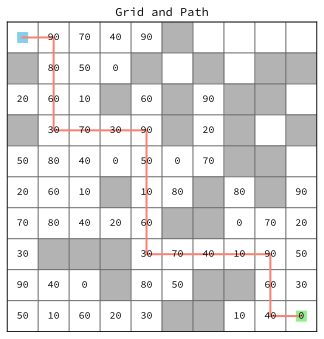

In [30]:
environment, grid = generate_environment()

if not start_simulation(environment=environment, grid=grid, algorithm="uniform_cost_search"):
    print("No path to the goal is found in the current environment!")
    print("Simulation failed!")

#### II. Simulation of A* (A Star) pathfinding algorithm

Paths Taken: [(0, 0), (0, 1), (1, 1), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (5, 4), (6, 4), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9)]
[100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 80, 70, 60, 50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
78
Trace: [(0, 1), (1, 1), (0, 2), (2, 1), (1, 2), (0, 3), (3, 1), (2, 0), (2, 2), (1, 3), (0, 4), (4, 1), (3, 2), (4, 2), (3, 3), (5, 1), (4, 0), (5, 2), (4, 3), (3, 4), (6, 1), (5, 0), (4, 4), (2, 4), (6, 0), (6, 2), (5, 4), (4, 5), (6, 3), (6, 4), (5, 5), (4, 6), (7, 4), (3, 6), (8, 4), (7, 5), (9, 4), (8, 5), (7, 6), (9, 3), (7, 7), (6, 7), (7, 8), (6, 8), (8, 8), (7, 9), (9, 8), (8, 9), (6, 9), (9, 9), (9, 7)]
Trace Batter

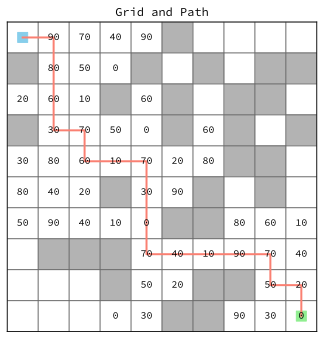

In [31]:
if not start_simulation(environment=environment, grid=grid, algorithm="a_star_search"):
    print("No path to the goal is found in the current environment!")
    print("Simulation failed!")